In [1]:
import pickle
import os
import sys
from statistics import mean
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
working_dir = os.getcwd()
os.chdir("../../..")
sys.path.append(os.getcwd())
from Internal_Representation.state import State
from Solver.action_tracker import ActionTracker
from runner import Runner
os.chdir(working_dir)

In [2]:
os.getcwd()

'F:\\Users\\Cael\\Documents\\University files\\4th Year\\Dissertation\\4th-Year-Dissertation\\Tests\\Evaluation\\Heuristic_Evaluation'

In [3]:
# Load pickled Object
def load_pickled_ob(file_name):
    with (open(file_name, "rb")) as openfile:
        while True:
            try:
                return pickle.load(openfile)
            except EOFError:
                break

In [4]:
# Display pickled actions_taken
def display_actions_taken(actions):
    for a in actions:
        print(a)

In [5]:
# Display pickled final state
def display_final_state(final_state):
    print(final_state)

In [6]:
size_dict = load_pickled_ob("problem_sizes.pickle")
size_dict

{'Basic/pb1.hddl': 46,
 'Rover/p01.hddl': 483,
 'Rover/p02.hddl': 486,
 'Rover/p03.hddl': 501,
 'Rover/p04.hddl': 554,
 'Rover/p05.hddl': 633,
 'Rover/p06.hddl': 648,
 'Rover/p07.hddl': 724,
 'Depots/p01.hddl': 302,
 'Depots/p02.hddl': 330,
 'Depots/p03.hddl': 358,
 'um-translog01/problem.hddl': 1395,
 'Factories/pfile01.hddl': 219,
 'Barman/pfile01.hddl': 514}

In [7]:
class average_time:
    def __init__(self):
        self.times = {} # {'roverp0': float}
        self.num_models = {}    # {'roverp0': float}

    def calculate_average_time(self, problem_name: str, times: list) -> None:
        self.times[problem_name] = mean(times)

    def calculate_average_model(self, problem_name: str, num_models: list) -> None:
        self.num_models[problem_name] = mean(num_models)

    def get_num_models(self, problem_name: str) -> float:
        return self.num_models[problem_name]

    def __getitem__(self, item):
        return self.times[item]

In [8]:
def generate_graph(example_names: list, config_names: list, colours: list, values: list,
                   title="Average Time Taken for Solving", y_axis="Average Time Taken (Seconds)"):
    assert len(config_names) == len(colours) == len(values)
    assert all([len(x) == len(example_names) for x in values])
    plt.figure(figsize=(18, 8))

    x_values = [size_dict[x] for x in example_names]

    i, l = 0, len(config_names)
    while i < l:
        y_values = [values[i][y] for y in range(len(values[i]))]
        plt.plot(x_values, y_values, 'bo-', label=r'{}'.format(config_names[i]), color=colours[i], alpha=0.6, linewidth=3)
        i += 1
    plt.xticks(x_values, [str(x) for x in x_values])
    plt.locator_params(axis='x', nbins=len(example_names))
    plt.xlabel('Problem Size'); plt.ylabel(r'{}'.format(y_axis))
    plt.title(r'{}'.format(title))
    plt.legend(loc='best')
    # plt.savefig("{}_ABS_features_Weight_plot.svg".format('lasso - Ridge'), dpi=500)  # Save graph to file
    plt.grid()

In [9]:
from scipy.stats import shapiro
from scipy.stats import kruskal
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
def significant_difference_check(list_approach_names: List[str], *args):
    """Check for statistically different data sets"""
    assert len(list_approach_names) == len(args)

    # Run shapiro test on all data
    data_values = [shapiro(x)[1] for x in args]
    data_normal = [x < 0.05 for x in data_values]

    # Assume we want to run dunn test
    run_dunn_test = True
    test_used = None

    # Run ANOVA or Kruskal test
    if all(x == False for x in data_normal):
        # Anova test
        print("All data is normally distributed")
        print("Shapiro p-values:", data_values)
        print("Non-Normal Check (False denoted non-normal):", data_normal)

        if len(list_approach_names) >= 3:
            # One-way ANOVA
            # https://statistics.laerd.com/statistical-guides/one-way-anova-statistical-guide.php
            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html
            res = f_oneway(*args)[1]
            test_used = "One-Way ANOVA"
        else:
            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
            assert len(list_approach_names) == 2
            run_dunn_test = False
            res = ttest_ind(args[0], args[1])[1]
            test_used = "T-Test"
    else:
        # Kruskals test
        print("NOT FOLLOWING NORMAL DISTRIBUTION")
        print("Shapiro p-values:", data_values)
        print("Non-Normal Check (False denotes non-normal):", data_normal)
        res = kruskal(*args)[1]
        test_used = "Kruskal-Wallis"

    if res <= 0.05:
        # There is significant difference
        print("Significant Difference found ({}). P-value: {}".format(test_used, res))
    else:
        # No significant difference
        print("NO Significant Difference found ({}). P-value: {}".format(test_used, res))
        run_dunn_test = False

    # Run Dunn Test
    if run_dunn_test:
        dunns_pairwise_test(list_approach_names, *args)

In [10]:
from scikit_posthocs import posthoc_dunn

def dunns_pairwise_test(list_approach_names: List[str], *args):

    d = []
    list_approach_names_extended = []
    i = 0
    while i < len(list_approach_names):
        for j in args[i]:
            d.append(j)
            list_approach_names_extended.append(list_approach_names[i])
        i += 1

    dataFrame = pd.DataFrame(list(zip(list_approach_names_extended, d)), columns=["Heuristic_Name", "Time_Taken"])
    # print(dataFrame)

    r = posthoc_dunn(dataFrame, "Time_Taken", "Heuristic_Name", p_adjust="hommel")
    print(r)

    # Print Results
    seen_pairs = []
    for i in r.keys():
        for j in r[i].keys():
            if j + i in seen_pairs:
                continue
            seen_pairs.append(i+j)

            if r[i][j] > 0.05 and i != j:
                print("No Significant Difference: {}, {} = {}".format(i, j, r[i][j]))
            elif i == j:
                pass
            else:
                print("Significant Difference: {}, {} = {}".format(i, j, r[i][j]))

# Running operations on collected Data

## Rover p0 -> p3 with early precondition checking and without

In [11]:
"""Load data from breadth first - no early precondition checker"""
breadth_first_no_early_precon_check_data_path = os.path.join(os.getcwd(), "Archive", "rover_no_early_precon", "Breadth_First_Operations.csv")
breadth_first_no_early_precon_check = pd.read_csv(breadth_first_no_early_precon_check_data_path, sep=",")

breadth_first_no_early_precon_check_av_time = average_time()
for example_name in breadth_first_no_early_precon_check.example_name.unique():

    breadth_first_no_early_precon_check_av_time.calculate_average_time(example_name, breadth_first_no_early_precon_check[breadth_first_no_early_precon_check['example_name'] == example_name]['time_taken'])

    breadth_first_no_early_precon_check_av_time.calculate_average_model(example_name,                               breadth_first_no_early_precon_check[breadth_first_no_early_precon_check['example_name'] == example_name]['search_models_created'])

breadth_first_no_early_precon_check

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.415648,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
1,Rover/p01.hddl,0.413664,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
2,Rover/p01.hddl,0.413168,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
3,Rover/p01.hddl,0.415648,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
4,Rover/p01.hddl,0.411184,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
5,Rover/p02.hddl,1.047552,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
6,Rover/p02.hddl,1.055984,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
7,Rover/p02.hddl,1.052016,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
8,Rover/p02.hddl,1.053008,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
9,Rover/p02.hddl,1.064416,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...


In [12]:
"""Load data from breadth first"""
breadth_first_data_path = os.path.join(os.getcwd(), "Archive", "Rover", "Breadth_First_Operations.csv")
breadth_first = pd.read_csv(breadth_first_data_path, sep=",")

breadth_first_data_path = os.path.join(os.getcwd(), "Archive", "Barman", "Breadth_First_Operations.csv")
breadth_first = pd.concat([breadth_first, pd.read_csv(breadth_first_data_path, sep=",")])

breadth_first_data_path = os.path.join(os.getcwd(), "Archive", "Depot", "Breadth_First_Operations.csv")
breadth_first = pd.concat([breadth_first, pd.read_csv(breadth_first_data_path, sep=",")])

breadth_first_data_path = os.path.join(os.getcwd(), "Archive", "Factories", "Breadth_First_Operations.csv")
breadth_first = pd.concat([breadth_first, pd.read_csv(breadth_first_data_path, sep=",")])

breadth_first_data_path = os.path.join(os.getcwd(), "Archive", "translog", "Breadth_First_Operations.csv")
breadth_first = pd.concat([breadth_first, pd.read_csv(breadth_first_data_path, sep=",")])

breadth_first_av_time = average_time()
for example_name in breadth_first.example_name.unique():

    breadth_first_av_time.calculate_average_time(example_name, breadth_first[breadth_first['example_name'] == example_name]['time_taken'])

    breadth_first_av_time.calculate_average_model(example_name, breadth_first[breadth_first['example_name'] == example_name]['search_models_created'])

breadth_first

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.621984,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
1,Rover/p01.hddl,0.408208,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
2,Rover/p01.hddl,0.399279,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
3,Rover/p01.hddl,0.395808,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
4,Rover/p01.hddl,0.419120,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
5,Rover/p02.hddl,1.004896,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
6,Rover/p02.hddl,1.031184,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
7,Rover/p02.hddl,1.025728,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
8,Rover/p02.hddl,1.021760,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
9,Rover/p02.hddl,1.041600,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...


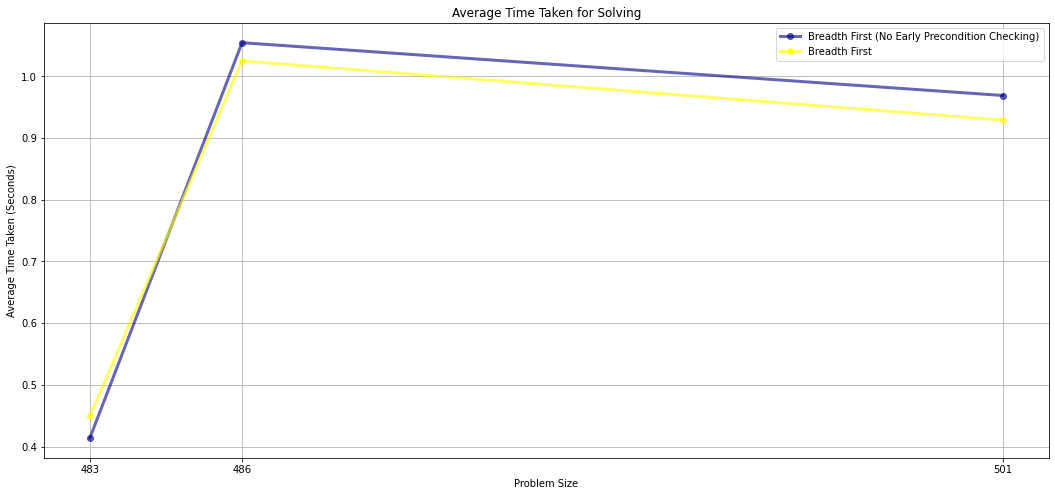

In [13]:
"""Create Graph"""
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl"], ["Breadth First (No Early Precondition Checking)", "Breadth First"], ["darkblue", "yellow"], [
[breadth_first_no_early_precon_check_av_time["Rover/p01.hddl"],
 breadth_first_no_early_precon_check_av_time["Rover/p02.hddl"],
 breadth_first_no_early_precon_check_av_time["Rover/p03.hddl"]],
[breadth_first_av_time["Rover/p01.hddl"],
 breadth_first_av_time["Rover/p02.hddl"],
 breadth_first_av_time["Rover/p03.hddl"]]
])

In [14]:
# Get test times for rover p01
no_precon_check = breadth_first_no_early_precon_check[breadth_first_no_early_precon_check['example_name'] == "Rover/p01.hddl"]['time_taken']
precon_check = breadth_first[breadth_first['example_name'] == "Rover/p01.hddl"]['time_taken']

print("Rover p01 Statistically Significant Test")
significant_difference_check(["Breadth First (No Early Precondition Checking)", "Breadth First"], no_precon_check, precon_check)

Rover p01 Statistically Significant Test
NOT FOLLOWING NORMAL DISTRIBUTION
Shapiro p-values: [0.4291726052761078, 0.0018502523889765143]
Non-Normal Check (False denotes non-normal): [False, True]
NO Significant Difference found (Kruskal-Wallis). P-value: 0.6015081344405895


In [15]:
# Get test times for rover p03
no_precon_check = breadth_first_no_early_precon_check[breadth_first_no_early_precon_check['example_name'] == "Rover/p02.hddl"]['time_taken']
precon_check = breadth_first[breadth_first['example_name'] == "Rover/p02.hddl"]['time_taken']

print("Rover p02 Statistically Significant Test")
significant_difference_check(["Breadth First (No Early Precondition Checking)", "Breadth First"], no_precon_check, precon_check)

Rover p02 Statistically Significant Test
All data is normally distributed
Shapiro p-values: [0.678989589214325, 0.9102689027786255]
Non-Normal Check (False denoted non-normal): [False, False]
Significant Difference found (T-Test). P-value: 0.002164764327749717


In [16]:
# Get test times for rover p03
no_precon_check = breadth_first_no_early_precon_check[breadth_first_no_early_precon_check['example_name'] == "Rover/p03.hddl"]['time_taken']
precon_check = breadth_first[breadth_first['example_name'] == "Rover/p03.hddl"]['time_taken']

print("Rover p03 Statistically Significant Test")
significant_difference_check(["Breadth First (No Early Precondition Checking)", "Breadth First"], no_precon_check, precon_check)

Rover p03 Statistically Significant Test
All data is normally distributed
Shapiro p-values: [0.30605143308639526, 0.21618331968784332]
Non-Normal Check (False denoted non-normal): [False, False]
Significant Difference found (T-Test). P-value: 6.733523612499041e-05


## Import Remainder of data
### Breadth First
### Breadth First Pruning
### Hamming Distance
### Tree Distance
### Delete Relaxed

In [17]:
breadth_first

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.621984,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
1,Rover/p01.hddl,0.408208,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
2,Rover/p01.hddl,0.399279,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
3,Rover/p01.hddl,0.395808,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
4,Rover/p01.hddl,0.419120,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
5,Rover/p02.hddl,1.004896,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
6,Rover/p02.hddl,1.031184,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
7,Rover/p02.hddl,1.025728,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
8,Rover/p02.hddl,1.021760,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
9,Rover/p02.hddl,1.041600,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...


In [18]:
"""Load data from breadth first pruning"""
breadth_first_pruning_data_path = os.path.join(os.getcwd(), "Archive", "Rover", "Breadth_First_Operations_Pruning.csv")
breadth_first_pruning = pd.read_csv(breadth_first_pruning_data_path, sep=",")

breadth_first_pruning_data_path = os.path.join(os.getcwd(), "Archive", "Barman", "Breadth_First_Operations_Pruning.csv")
breadth_first_pruning = pd.concat([breadth_first_pruning, pd.read_csv(breadth_first_pruning_data_path, sep=",")])

breadth_first_pruning_data_path = os.path.join(os.getcwd(), "Archive", "Depot", "Breadth_First_Operations_Pruning.csv")
breadth_first_pruning = pd.concat([breadth_first_pruning, pd.read_csv(breadth_first_pruning_data_path, sep=",")])

breadth_first_pruning_data_path = os.path.join(os.getcwd(), "Archive", "Factories", "Breadth_First_Operations_Pruning.csv")
breadth_first_pruning = pd.concat([breadth_first_pruning, pd.read_csv(breadth_first_pruning_data_path, sep=",")])

breadth_first_pruning_data_path = os.path.join(os.getcwd(), "Archive", "translog", "Breadth_First_Operations_Pruning.csv")
breadth_first_pruning = pd.concat([breadth_first_pruning, pd.read_csv(breadth_first_pruning_data_path, sep=",")])

breadth_first_pruning_av_time = average_time()
for example_name in breadth_first_pruning.example_name.unique():
    breadth_first_pruning_av_time.calculate_average_time(example_name, breadth_first_pruning[breadth_first_pruning['example_name'] == example_name]['time_taken'])

    breadth_first_pruning_av_time.calculate_average_model(example_name, breadth_first_pruning[breadth_first_pruning['example_name'] == example_name]['search_models_created'])

breadth_first_pruning

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.079360,507,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
1,Rover/p01.hddl,0.064976,507,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
2,Rover/p01.hddl,0.064480,507,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
3,Rover/p01.hddl,0.064976,507,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
4,Rover/p01.hddl,0.064480,507,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
5,Rover/p02.hddl,0.100191,817,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
6,Rover/p02.hddl,0.094240,817,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
7,Rover/p02.hddl,0.093744,817,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
8,Rover/p02.hddl,0.102175,817,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
9,Rover/p02.hddl,0.093248,817,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...


In [19]:
"""Load data for Hamming Distance"""
hamming_distance_data_path = os.path.join(os.getcwd(), "Archive", "Rover", "Hamming_Distance.csv")
hamming_distance = pd.read_csv(hamming_distance_data_path, sep=",")

hamming_distance_data_path = os.path.join(os.getcwd(), "Archive", "Barman", "Hamming_Distance.csv")
hamming_distance = pd.concat([hamming_distance, pd.read_csv(hamming_distance_data_path, sep=",")])

hamming_distance_data_path = os.path.join(os.getcwd(), "Archive", "Depot", "Hamming_Distance.csv")
hamming_distance = pd.concat([hamming_distance, pd.read_csv(hamming_distance_data_path, sep=",")])

hamming_distance_data_path = os.path.join(os.getcwd(), "Archive", "Factories", "Hamming_Distance.csv")
hamming_distance = pd.concat([hamming_distance, pd.read_csv(hamming_distance_data_path, sep=",")])

hamming_distance_data_path = os.path.join(os.getcwd(), "Archive", "translog", "Hamming_Distance.csv")
hamming_distance = pd.concat([hamming_distance, pd.read_csv(hamming_distance_data_path, sep=",")])

hamming_distance_av_time = average_time()
for example_name in hamming_distance.example_name.unique():
    hamming_distance_av_time.calculate_average_time(example_name, hamming_distance[hamming_distance['example_name'] == example_name]['time_taken'])

    hamming_distance_av_time.calculate_average_model(example_name, hamming_distance[hamming_distance['example_name'] == example_name]['search_models_created'])

hamming_distance

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.033231,216,serialised_objects\Rover_p01hddl_Hamming_Dista...,serialised_objects\Rover_p01hddl_Hamming_Dista...
1,Rover/p01.hddl,0.033728,216,serialised_objects\Rover_p01hddl_Hamming_Dista...,serialised_objects\Rover_p01hddl_Hamming_Dista...
2,Rover/p01.hddl,0.033728,216,serialised_objects\Rover_p01hddl_Hamming_Dista...,serialised_objects\Rover_p01hddl_Hamming_Dista...
3,Rover/p01.hddl,0.034720,216,serialised_objects\Rover_p01hddl_Hamming_Dista...,serialised_objects\Rover_p01hddl_Hamming_Dista...
4,Rover/p01.hddl,0.033232,216,serialised_objects\Rover_p01hddl_Hamming_Dista...,serialised_objects\Rover_p01hddl_Hamming_Dista...
...,...,...,...,...,...
0,um-translog01/problem.hddl,0.107632,1289,serialised_objects\um-translog01_problemhddl_H...,serialised_objects\um-translog01_problemhddl_H...
1,um-translog01/problem.hddl,0.102176,1289,serialised_objects\um-translog01_problemhddl_H...,serialised_objects\um-translog01_problemhddl_H...
2,um-translog01/problem.hddl,0.103168,1289,serialised_objects\um-translog01_problemhddl_H...,serialised_objects\um-translog01_problemhddl_H...
3,um-translog01/problem.hddl,0.109120,1289,serialised_objects\um-translog01_problemhddl_H...,serialised_objects\um-translog01_problemhddl_H...


In [20]:
"""Load data for Tree Distance"""
tree_distance_data_path = os.path.join(os.getcwd(), "Archive", "Rover", "Tree_Distance.csv")
tree_distance = pd.read_csv(tree_distance_data_path, sep=",")

tree_distance_data_path = os.path.join(os.getcwd(), "Archive", "Barman", "Tree_Distance.csv")
tree_distance = pd.concat([tree_distance, pd.read_csv(tree_distance_data_path, sep=",")])

tree_distance_data_path = os.path.join(os.getcwd(), "Archive", "Depot", "Tree_Distance.csv")
tree_distance = pd.concat([tree_distance, pd.read_csv(tree_distance_data_path, sep=",")])

tree_distance_data_path = os.path.join(os.getcwd(), "Archive", "Factories", "Tree_Distance.csv")
tree_distance = pd.concat([tree_distance, pd.read_csv(tree_distance_data_path, sep=",")])

tree_distance_data_path = os.path.join(os.getcwd(), "Archive", "translog", "Tree_Distance.csv")
tree_distance = pd.concat([tree_distance, pd.read_csv(tree_distance_data_path, sep=",")])

tree_distance_av_time = average_time()
for example_name in tree_distance.example_name.unique():
    tree_distance_av_time.calculate_average_time(example_name, tree_distance[tree_distance['example_name'] == example_name]['time_taken'])

    tree_distance_av_time.calculate_average_model(example_name, tree_distance[tree_distance['example_name'] == example_name]['search_models_created'])

tree_distance

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.070432,442,serialised_objects\Rover_p01hddl_Tree_Distance...,serialised_objects\Rover_p01hddl_Tree_Distance...
1,Rover/p01.hddl,0.065470,442,serialised_objects\Rover_p01hddl_Tree_Distance...,serialised_objects\Rover_p01hddl_Tree_Distance...
2,Rover/p01.hddl,0.063487,442,serialised_objects\Rover_p01hddl_Tree_Distance...,serialised_objects\Rover_p01hddl_Tree_Distance...
3,Rover/p01.hddl,0.063488,442,serialised_objects\Rover_p01hddl_Tree_Distance...,serialised_objects\Rover_p01hddl_Tree_Distance...
4,Rover/p01.hddl,0.290159,442,serialised_objects\Rover_p01hddl_Tree_Distance...,serialised_objects\Rover_p01hddl_Tree_Distance...
5,Rover/p02.hddl,0.075392,448,serialised_objects\Rover_p02hddl_Tree_Distance...,serialised_objects\Rover_p02hddl_Tree_Distance...
6,Rover/p02.hddl,0.077376,448,serialised_objects\Rover_p02hddl_Tree_Distance...,serialised_objects\Rover_p02hddl_Tree_Distance...
7,Rover/p02.hddl,0.075392,448,serialised_objects\Rover_p02hddl_Tree_Distance...,serialised_objects\Rover_p02hddl_Tree_Distance...
8,Rover/p02.hddl,0.075888,448,serialised_objects\Rover_p02hddl_Tree_Distance...,serialised_objects\Rover_p02hddl_Tree_Distance...
9,Rover/p02.hddl,0.083328,448,serialised_objects\Rover_p02hddl_Tree_Distance...,serialised_objects\Rover_p02hddl_Tree_Distance...


In [21]:
"""Load data for Delete Relaxed"""
delete_relaxed_data_path = os.path.join(os.getcwd(), "Archive", "Rover", "Delete_Relaxed.csv")
delete_relaxed = pd.read_csv(delete_relaxed_data_path, sep=",")

delete_relaxed_data_path = os.path.join(os.getcwd(), "Archive", "Barman", "Delete_Relaxed.csv")
delete_relaxed = pd.concat([delete_relaxed, pd.read_csv(delete_relaxed_data_path, sep=",")])

delete_relaxed_data_path = os.path.join(os.getcwd(), "Archive", "translog", "Delete_Relaxed.csv")
delete_relaxed = pd.concat([delete_relaxed, pd.read_csv(delete_relaxed_data_path, sep=",")])

delete_relaxed_av_time = average_time()
for example_name in delete_relaxed.example_name.unique():
    delete_relaxed_av_time.calculate_average_time(example_name, delete_relaxed[delete_relaxed['example_name'] == example_name]['time_taken'])

    delete_relaxed_av_time.calculate_average_model(example_name, delete_relaxed[delete_relaxed['example_name'] == example_name]['search_models_created'])

delete_relaxed

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,8.003953,645,serialised_objects\Rover_p01hddl_Delete_Relaxe...,serialised_objects\Rover_p01hddl_Delete_Relaxe...
1,Rover/p01.hddl,7.792160,645,serialised_objects\Rover_p01hddl_Delete_Relaxe...,serialised_objects\Rover_p01hddl_Delete_Relaxe...
2,Rover/p01.hddl,7.669649,645,serialised_objects\Rover_p01hddl_Delete_Relaxe...,serialised_objects\Rover_p01hddl_Delete_Relaxe...
3,Rover/p01.hddl,7.572928,645,serialised_objects\Rover_p01hddl_Delete_Relaxe...,serialised_objects\Rover_p01hddl_Delete_Relaxe...
4,Rover/p01.hddl,7.596241,645,serialised_objects\Rover_p01hddl_Delete_Relaxe...,serialised_objects\Rover_p01hddl_Delete_Relaxe...
0,Barman/pfile01.hddl,63.292086,20866,serialised_objects\Barman_pfile01hddl_Delete_R...,serialised_objects\Barman_pfile01hddl_Delete_R...
1,Barman/pfile01.hddl,63.556950,20866,serialised_objects\Barman_pfile01hddl_Delete_R...,serialised_objects\Barman_pfile01hddl_Delete_R...
2,Barman/pfile01.hddl,64.622856,20866,serialised_objects\Barman_pfile01hddl_Delete_R...,serialised_objects\Barman_pfile01hddl_Delete_R...
3,Barman/pfile01.hddl,62.152277,20866,serialised_objects\Barman_pfile01hddl_Delete_R...,serialised_objects\Barman_pfile01hddl_Delete_R...
4,Barman/pfile01.hddl,63.106086,20866,serialised_objects\Barman_pfile01hddl_Delete_R...,serialised_objects\Barman_pfile01hddl_Delete_R...


## Graph for All Delete Relaxed Problems (Includes all heuristics)

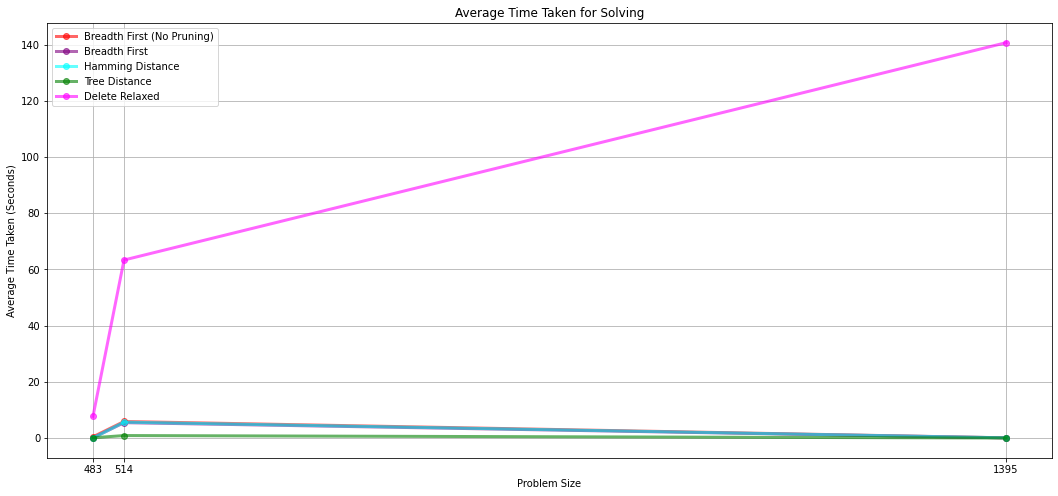

In [30]:
generate_graph(["Rover/p01.hddl", "Barman/pfile01.hddl", "um-translog01/problem.hddl"], ["Breadth First (No Pruning)", "Breadth First", "Hamming Distance", "Tree Distance", "Delete Relaxed"], ["red", "purple", "aqua", "green", "magenta"],
               [
                   [breadth_first_av_time["Rover/p01.hddl"],
                    breadth_first_av_time["Barman/pfile01.hddl"],
                    breadth_first_av_time["um-translog01/problem.hddl"]],
                   [breadth_first_pruning_av_time["Rover/p01.hddl"],
                    breadth_first_pruning_av_time["Barman/pfile01.hddl"],
                    breadth_first_pruning_av_time["um-translog01/problem.hddl"]],
                   [hamming_distance_av_time["Rover/p01.hddl"],
                    hamming_distance_av_time["Barman/pfile01.hddl"],
                    hamming_distance_av_time["um-translog01/problem.hddl"]],
                   [tree_distance_av_time["Rover/p01.hddl"],
                    tree_distance_av_time["Barman/pfile01.hddl"],
                    tree_distance_av_time["um-translog01/problem.hddl"]],
                   [delete_relaxed_av_time["Rover/p01.hddl"],
                    delete_relaxed_av_time["Barman/pfile01.hddl"],
                    delete_relaxed_av_time["um-translog01/problem.hddl"]]
               ])

## Same Graph as above with no Delete Relaxed

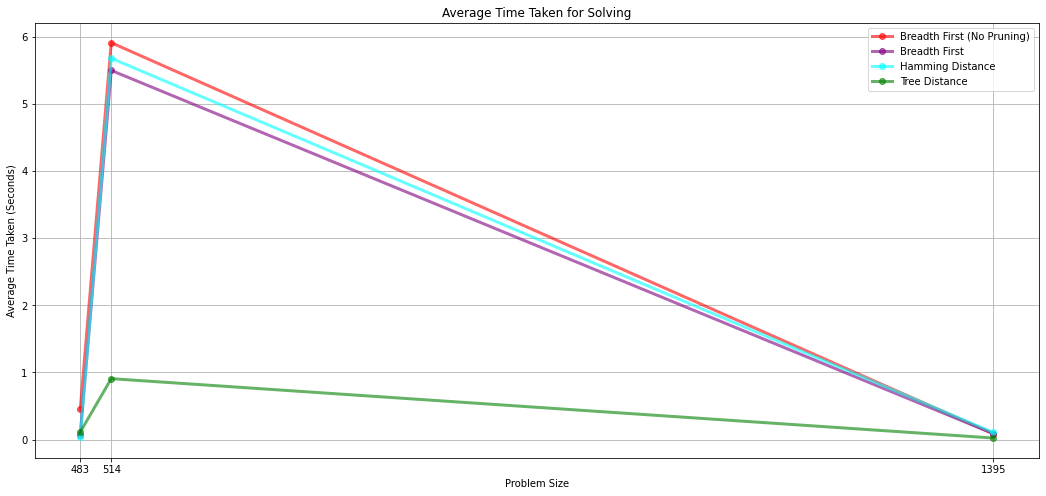

In [29]:
generate_graph(["Rover/p01.hddl", "Barman/pfile01.hddl", "um-translog01/problem.hddl"], ["Breadth First (No Pruning)", "Breadth First", "Hamming Distance", "Tree Distance"], ["red", "purple", "aqua", "green"],
               [
                   [breadth_first_av_time["Rover/p01.hddl"],
                    breadth_first_av_time["Barman/pfile01.hddl"],
                    breadth_first_av_time["um-translog01/problem.hddl"]],
                   [breadth_first_pruning_av_time["Rover/p01.hddl"],
                    breadth_first_pruning_av_time["Barman/pfile01.hddl"],
                    breadth_first_pruning_av_time["um-translog01/problem.hddl"]],
                   [hamming_distance_av_time["Rover/p01.hddl"],
                    hamming_distance_av_time["Barman/pfile01.hddl"],
                    hamming_distance_av_time["um-translog01/problem.hddl"]],
                   [tree_distance_av_time["Rover/p01.hddl"],
                    tree_distance_av_time["Barman/pfile01.hddl"],
                    tree_distance_av_time["um-translog01/problem.hddl"]]
               ])

## Graph for Rover p1 -> p3

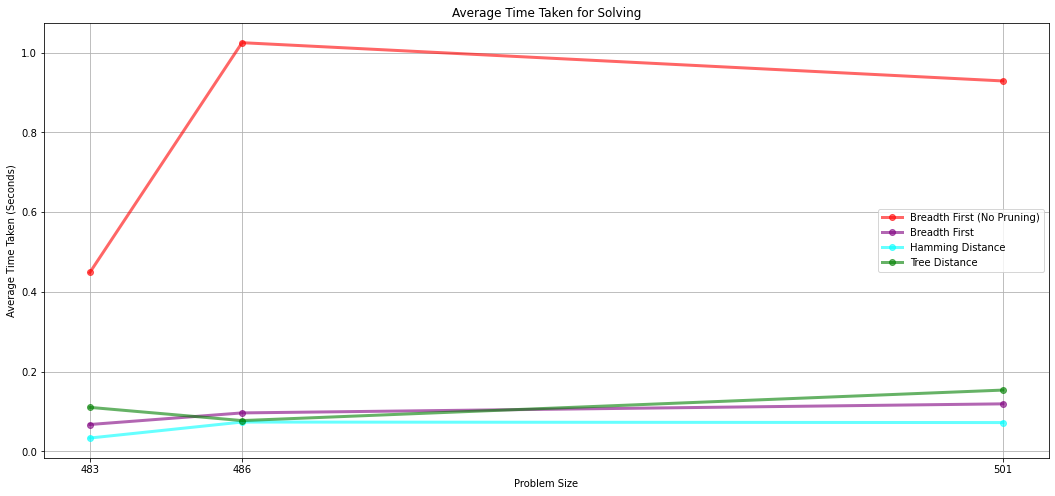

In [22]:
"""Create Graph"""
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl"], ["Breadth First (No Pruning)", "Breadth First", "Hamming Distance", "Tree Distance"], ["red", "purple", "aqua", "green"],
[
    [breadth_first_av_time["Rover/p01.hddl"],
     breadth_first_av_time["Rover/p02.hddl"],
     breadth_first_av_time["Rover/p03.hddl"]],
    [breadth_first_pruning_av_time["Rover/p01.hddl"],
     breadth_first_pruning_av_time["Rover/p02.hddl"],
     breadth_first_pruning_av_time["Rover/p03.hddl"]],
    [hamming_distance_av_time["Rover/p01.hddl"],
     hamming_distance_av_time["Rover/p02.hddl"],
     hamming_distance_av_time["Rover/p03.hddl"]],
    [tree_distance_av_time["Rover/p01.hddl"],
     tree_distance_av_time["Rover/p02.hddl"],
     tree_distance_av_time["Rover/p03.hddl"]]
])

In [23]:
# Get test times for rover p01
BF_pruning = breadth_first_pruning[breadth_first_pruning['example_name'] == "Rover/p01.hddl"]['time_taken']
precon_check = breadth_first[breadth_first['example_name'] == "Rover/p01.hddl"]['time_taken']
hamming_distance_times = hamming_distance[hamming_distance['example_name'] == "Rover/p01.hddl"]['time_taken']

print("Rover p01 Statistically Significant Test")
significant_difference_check(["Breadth First", "Breadth First (No Pruning)", "Hamming Distance"], BF_pruning, precon_check, hamming_distance_times)

Rover p01 Statistically Significant Test
NOT FOLLOWING NORMAL DISTRIBUTION
Shapiro p-values: [0.00038057329948060215, 0.0018502523889765143, 0.14629341661930084]
Non-Normal Check (False denotes non-normal): [True, True, False]
Significant Difference found (Kruskal-Wallis). P-value: 0.0019304541362277095
                            Breadth First  Breadth First (No Pruning)  \
Breadth First                      1.0000                    0.077100   
Breadth First (No Pruning)         0.0771                    1.000000   
Hamming Distance                   0.0771                    0.001221   

                            Hamming Distance  
Breadth First                       0.077100  
Breadth First (No Pruning)          0.001221  
Hamming Distance                    1.000000  
No Significant Difference: Breadth First, Breadth First (No Pruning) = 0.07709987174354177
No Significant Difference: Breadth First, Hamming Distance = 0.07709987174354177
Significant Difference: Breadth First (No 

In [24]:
# Get test times for rover p02
BF_pruning = breadth_first_pruning[breadth_first_pruning['example_name'] == "Rover/p02.hddl"]['time_taken']
precon_check = breadth_first[breadth_first['example_name'] == "Rover/p02.hddl"]['time_taken']
hamming_distance_times = hamming_distance[hamming_distance['example_name'] == "Rover/p02.hddl"]['time_taken']

print("Rover p02 Statistically Significant Test")
significant_difference_check(["Breadth First", "Breadth First (No Pruning)", "Hamming Distance"], BF_pruning, precon_check, hamming_distance_times)

Rover p02 Statistically Significant Test
NOT FOLLOWING NORMAL DISTRIBUTION
Shapiro p-values: [0.1057223379611969, 0.9102689027786255, 0.0005547322216443717]
Non-Normal Check (False denotes non-normal): [False, False, True]
Significant Difference found (Kruskal-Wallis). P-value: 0.0019304541362277095
                            Breadth First  Breadth First (No Pruning)  \
Breadth First                      1.0000                    0.077100   
Breadth First (No Pruning)         0.0771                    1.000000   
Hamming Distance                   0.0771                    0.001221   

                            Hamming Distance  
Breadth First                       0.077100  
Breadth First (No Pruning)          0.001221  
Hamming Distance                    1.000000  
No Significant Difference: Breadth First, Breadth First (No Pruning) = 0.07709987174354177
No Significant Difference: Breadth First, Hamming Distance = 0.07709987174354177
Significant Difference: Breadth First (No Prun

In [25]:
# Get test times for rover p03
BF_pruning = breadth_first_pruning[breadth_first_pruning['example_name'] == "Rover/p03.hddl"]['time_taken']
precon_check = breadth_first[breadth_first['example_name'] == "Rover/p03.hddl"]['time_taken']
hamming_distance_times = hamming_distance[hamming_distance['example_name'] == "Rover/p03.hddl"]['time_taken']

print("Rover p03 Statistically Significant Test")
significant_difference_check(["Breadth First", "Breadth First (No Pruning)", "Hamming Distance"], BF_pruning, precon_check, hamming_distance_times)

Rover p03 Statistically Significant Test
NOT FOLLOWING NORMAL DISTRIBUTION
Shapiro p-values: [0.06637930124998093, 0.21618331968784332, 0.0067518618889153]
Non-Normal Check (False denotes non-normal): [False, False, True]
Significant Difference found (Kruskal-Wallis). P-value: 0.0019304541362277095
                            Breadth First  Breadth First (No Pruning)  \
Breadth First                      1.0000                    0.077100   
Breadth First (No Pruning)         0.0771                    1.000000   
Hamming Distance                   0.0771                    0.001221   

                            Hamming Distance  
Breadth First                       0.077100  
Breadth First (No Pruning)          0.001221  
Hamming Distance                    1.000000  
No Significant Difference: Breadth First, Breadth First (No Pruning) = 0.07709987174354177
No Significant Difference: Breadth First, Hamming Distance = 0.07709987174354177
Significant Difference: Breadth First (No Pruni

## Graph with:
### Rover

## Rover p01 -> p07 pruning and predicate_distance
For this test, the breadth first non-pruning search strategy was run for 2 hours and was not able to produce a result

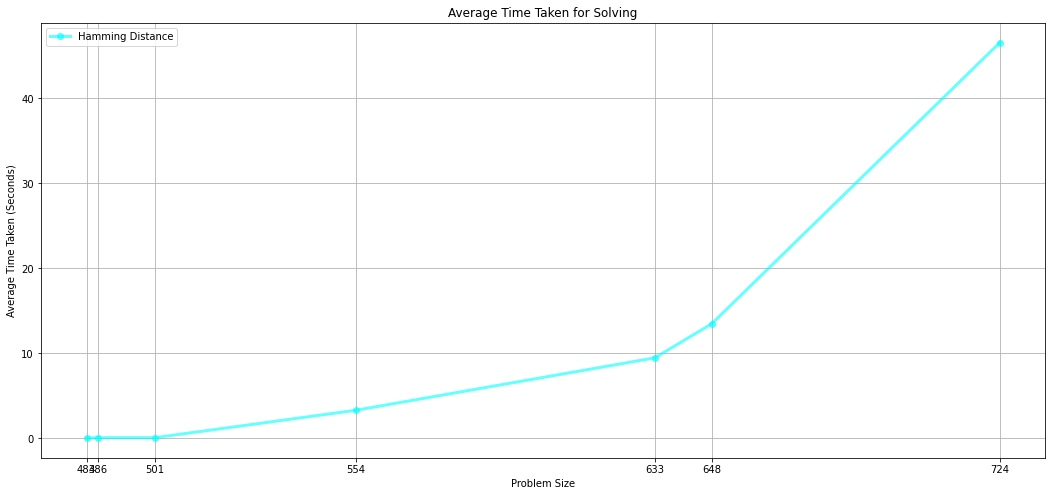

In [32]:
"""Create Graph"""
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl", "Rover/p04.hddl", "Rover/p05.hddl",
                "Rover/p06.hddl", "Rover/p07.hddl"],
               ["Hamming Distance"], ["aqua"],
               [
                   [hamming_distance_av_time["Rover/p01.hddl"],
                    hamming_distance_av_time["Rover/p02.hddl"],
                    hamming_distance_av_time["Rover/p03.hddl"],
                    hamming_distance_av_time["Rover/p04.hddl"],
                    hamming_distance_av_time["Rover/p05.hddl"],
                    hamming_distance_av_time["Rover/p06.hddl"],
                    hamming_distance_av_time["Rover/p07.hddl"]]
               ])

In [ ]:
"""Stats Tests"""

# Graph number of models created during search

## Rover p0 -> p3. Breadth first, breadth first with pruning, predicate distance to goal

In [ ]:
"""Create Graph"""
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl"], ["Breadth First (No Pruning)", "Breadth First", "Predicate Distance To Goal Heuristic"], ["red", "purple", "aqua"],
               [
                   [breadth_first_av_time.get_num_models("Rover/p01.hddl"),
                    breadth_first_av_time.get_num_models("Rover/p02.hddl"),
                    breadth_first_av_time.get_num_models("Rover/p03.hddl")],
                   [breadth_first_pruning_av_time.get_num_models("Rover/p01.hddl"),
                    breadth_first_pruning_av_time.get_num_models("Rover/p02.hddl"),
                    breadth_first_pruning_av_time.get_num_models("Rover/p03.hddl")],
                   [predicate_distance_to_goal_av_time.get_num_models("Rover/p01.hddl"),
                    predicate_distance_to_goal_av_time.get_num_models("Rover/p02.hddl"),
                    predicate_distance_to_goal_av_time.get_num_models("Rover/p03.hddl")]
               ], "Amount of Models Created During Search", "Number of Models")

# Graph number of models created during search

## Rover p0 -> p3. Breadth first, breadth first with pruning, predicate distance to goal

In [ ]:
"""Create Graph"""
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl"], ["Breadth First (No Pruning)", "Breadth First", "Predicate Distance To Goal Heuristic"], ["red", "purple", "aqua"],
               [
                   [breadth_first_av_time.get_num_models("Rover/p01.hddl"),
                    breadth_first_av_time.get_num_models("Rover/p02.hddl"),
                    breadth_first_av_time.get_num_models("Rover/p03.hddl")],
                   [breadth_first_pruning_av_time.get_num_models("Rover/p01.hddl"),
                    breadth_first_pruning_av_time.get_num_models("Rover/p02.hddl"),
                    breadth_first_pruning_av_time.get_num_models("Rover/p03.hddl")],
                   [predicate_distance_to_goal_av_time.get_num_models("Rover/p01.hddl"),
                    predicate_distance_to_goal_av_time.get_num_models("Rover/p02.hddl"),
                    predicate_distance_to_goal_av_time.get_num_models("Rover/p03.hddl")]
               ], "Amount of Models Created During Search", "Number of Models")

# Area for checking serialised files

In [ ]:
file_name = predicate_distance_to_goal.iloc[0]['serialised_actions_taken']
actions_taken = load_pickled_ob(file_name)
display_actions_taken(actions_taken)

In [ ]:
file_name = predicate_distance_to_goal.iloc[0]['serialised_state']
final_state = load_pickled_ob(file_name)
display_final_state(final_state)